# Optimisation in a transformed parameter space

This example shows you how to run an optimisation in a transformed parameter space, using a [pints.Transformation](https://pints.readthedocs.io/en/latest/transformations.html#pints.Transformation) object.

Parameter transformations can often significantly improve the performance and robustness of an optimisation (see e.g. \[1\]).
In addition, some methods have requirements (e.g. that all parameters are unconstrained, or that all parameters have similar magnitudes) that prevent them from being used on certain models in their untransformed form.

\[1\]  Whittaker, DG, Clerx, M, Lei, CL, Christini, DJ, Mirams, GR. Calibration of ionic and cellular cardiac electrophysiology models. WIREs Syst Biol Med. 2020; 12:e1482. <https://doi.org/10.1002/wsbm.1482>

We start by loading a ``pints.Forwardmodel`` implementation, in this case a [logistic model](https://pints.readthedocs.io/en/latest/toy/logistic_model.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy as toy

# Set some random seed so this notebook can be reproduced
np.random.seed(10)

# Load a logistic forward model
model = toy.LogisticModel()

We then define some parameters and set up the problem for the optimisation.
The parameter vector for the toy logistic model is $\theta_\text{original} = [r, K]$, where $r$ is the _growth rate_ and $K$ is called the _carrying capacity_.

In [2]:
# Create some toy data
real_parameters = [0.015, 400]  # [r, K]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

In this example, we will pick some difficult starting points for the optimisation:

In [3]:
x0 = [0.5, 0.1]  # [r, K]
sigma0 = [0.01, 2.0]

Now we run a Nelder-Mead optimisation without doing any parameter transformation to check its performance.

Minimising error measure
Using Nelder-Mead
Running in sequential mode.
Iter. Eval. Best      Time m:s
0     3      9.27e+07   0:00.0
1     4      9.27e+07   0:00.0
2     5      9.27e+07   0:00.0
3     6      9.27e+07   0:00.0
20    23     9.26e+07   0:00.0
40    43     9.25e+07   0:00.0
60    63     7.7e+07    0:00.0
80    83     2.58e+07   0:00.0
100   103    2.58e+07   0:00.0
120   123    2.58e+07   0:00.0
140   143    2.58e+07   0:00.0
160   167    2.58e+07   0:00.0
180   192    2.58e+07   0:00.0
200   217    2.58e+07   0:00.0
220   242    2.58e+07   0:00.0
240   269    2.58e+07   0:00.0
260   295    2.58e+07   0:00.0
280   322    2.58e+07   0:00.0
300   349    2.58e+07   0:00.0
320   375    2.58e+07   0:00.0
340   402    2.58e+07   0:00.0
360   429    2.58e+07   0:00.0
371   442    2.58e+07   0:00.0
Halting: No significant change for 200 iterations.
Score at true solution: 
87997.66499248528
Found solution:          True parameters:
 1.14854472655286514e+02     1.49999999999999994e

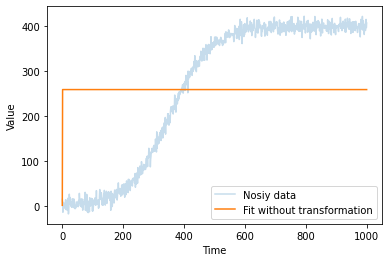

In [4]:
found_parameters, found_value = pints.optimise(
    score,
    x0,
    sigma0,
    method=pints.NelderMead,
    transformation=None,
)

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values, alpha=0.25, label='Nosiy data')
plt.plot(times, problem.evaluate(found_parameters), label='Fit without transformation')
plt.legend()
plt.show()

As we can see, the optimiser made some initial improvements, but then got stuck somewhere in $[r, K]$ space, and failed to converge to the true parameters.

We can improve its performance by defining a parameter transformation so that it searches in $\theta = [r, \log(K)]$ space instead.
To do this, we'll create a [pints.Transformation](https://pints.readthedocs.io/en/latest/transformations.html#pints.Transformation) object, that leaves $r$ alone, but applies a log-transformation to $K$.
This is implemented by defining an ``IdentifyTransformation`` for $r$, a ``LogTransformation`` for $K$, and then creating a ``ComposedTransformation`` for the full parameter vector $\theta$:

In [5]:
# No transformation: [r] -> [r]
transform_r = pints.IdentityTransformation(n_parameters=1)
# Log-transformation: [K] -> [log(K)]
transform_K = pints.LogTransformation(n_parameters=1)

# The full transformation: [r, K] -> [r, log(K)]
transformation = pints.ComposedTransformation(transform_r, transform_K)

The resulting ``Transformation`` object can be passed in the ``optimise`` method, as shown below, but can also be used in combination with ``Controller`` classes such as the [pints.OptimisationController](https://pints.readthedocs.io/en/latest/optimisers/running.html#pints.OptimisationController) or [pints.MCMCController](https://pints.readthedocs.io/en/latest/mcmc_samplers/running.html#pints.MCMCController).

Minimising error measure
Using Nelder-Mead
Running in sequential mode.
Iter. Eval. Best      Time m:s
0     3      9.27e+07   0:00.0
1     4      9.27e+07   0:00.0
2     5      9.27e+07   0:00.0
3     6      9.26e+07   0:00.0
20    23     2.78e+07   0:00.0
40    43     2.54e+07   0:00.0
60    63     1.84e+07   0:00.0
80    83     9615881    0:00.0
100   103    126525.8   0:00.0
120   123    87941.33   0:00.0
140   143    87740.45   0:00.0
160   163    87740.34   0:00.0
180   183    87740.34   0:00.0
200   203    87740.34   0:00.0
220   223    87740.34   0:00.0
240   248    87740.34   0:00.0
260   272    87740.34   0:00.0
280   297    87740.34   0:00.0
300   323    87740.34   0:00.0
320   350    87740.34   0:00.0
340   377    87740.34   0:00.0
360   403    87740.34   0:00.0
380   430    87740.34   0:00.1
400   457    87740.34   0:00.1
420   483    87740.34   0:00.1
440   510    87740.34   0:00.1
460   537    87740.34   0:00.1
480   563    87740.34   0:00.1
483   566    87740.34   0:00.1

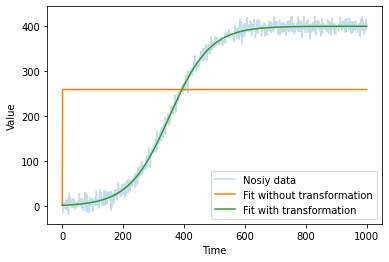

In [6]:
found_parameters_trans, found_value_trans = pints.optimise(
    score,
    x0,
    sigma0,
    method=pints.NelderMead,
    transformation=transformation,  # Pass the transformation to the optimiser
)

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters_trans):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values, alpha=0.25, label='Nosiy data')
plt.plot(times, problem.evaluate(found_parameters), label='Fit without transformation')
plt.plot(times, problem.evaluate(found_parameters_trans), label='Fit with transformation')
plt.legend()
plt.show()